### **ICESat-2数据处理**

In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from shapely.geometry import Point
from pyrsimg import readTiff, imgShow, geo2imagexy


In [21]:
path_atl06 = 'data/laser/isat2_gla_region.h5'
path_rsimg = 'data/rsimg/s2_gla_region_20220707.tif'
path_dem = 'data/srtm/SRTMGL1Ellip_gla_region.tif'
path_gla_vec = 'data/laser/gla_region.gpkg'


In [22]:
!h5ls $path_atl06
# !h5ls $path_atl06/gt1l/land_ice_segments
# !h5ls $path_atl06/orbit_info


cycle                    Dataset {SCALAR}
elev                     Dataset {4269}
lat                      Dataset {4269}
lon                      Dataset {4269}
orient                   Dataset {SCALAR}
time_delta               Dataset {4269}
time_dyr                 Dataset {4269}
track                    Dataset {SCALAR}


In [23]:
vars_atl06 = {'lat':[], 'lon':[], 'time_dyr':[], 'elev':[]}
beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
with h5py.File(path_atl06,'r') as gla_atl06:
    # for beam in beams:
    vars_atl06['lat'] = gla_atl06['lat'][:]
    vars_atl06['lon'] = gla_atl06['lon'][:]
    vars_atl06['time_dyr'] = gla_atl06['time_dyr'][:]
    vars_atl06['elev'] = gla_atl06['elev'][:]
    print(vars_atl06['lat'].shape)

## 2. remote sensing image
rsimg = readTiff(path_rsimg)
## 3. dem image
dem = readTiff(path_dem)
## 4. glacier region
gla_vec = gpd.read_file(path_gla_vec)


(4269,)


<Axes: >

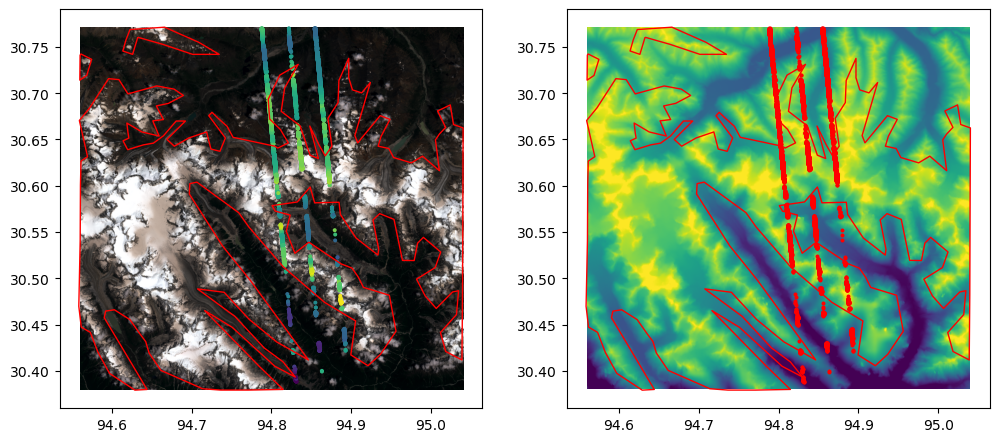

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
imgShow(rsimg.array, extent=rsimg.geoextent, per_band_clip=10, ax=ax[0])
ax[0].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c=vars_atl06['elev'], s=3.5)
imgShow(dem.array, extent=dem.geoextent, ax=ax[1])
ax[1].scatter(x=vars_atl06['lon'], y=vars_atl06['lat'], c='red', s=3.5)
gla_vec.plot(ax=ax[0], facecolor="none", edgecolor='red')
gla_vec.plot(ax=ax[1], facecolor="none", edgecolor='red')


In [25]:
## 筛选出冰川点
ids_gla = np.zeros(shape=(vars_atl06['lon'].shape))
for i, lon in enumerate(vars_atl06['lon']):
    point = Point(lon, vars_atl06['lat'][i])
    if gla_vec.geometry[0].contains(point):
        ids_gla[i]=1
ids_gla


array([0., 0., 0., ..., 0., 0., 0.], shape=(4269,))

In [26]:
row, col = geo2imagexy(x=vars_atl06['lon'], \
                         y=vars_atl06['lat'], \
                         rsimg_array=dem.array, \
                         gdal_trans=dem.geotrans, \
                         integer=True)
dem_isat2_fp = dem.array[row, col]
dem_isat2_fp[90:100]


array([3419.73852539, 3421.73901367, 3422.74169922, 3425.7421875 ,
       3764.7512207 , 3884.75488281, 3884.75488281, 4015.75805664,
       4038.77197266, 5187.82714844])

Text(0.5, 1.0, 'measurements on non-glacier region')

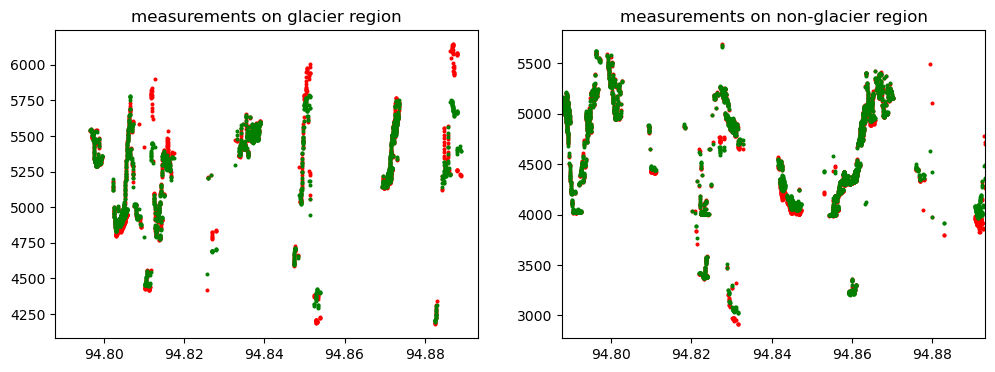

In [27]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
### glacier region
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=vars_atl06['elev'][ids_gla==1], c='red', s=3.5)  ## icesat data
ax[0].scatter(x=vars_atl06['lon'][ids_gla==1], y=dem_isat2_fp[ids_gla==1], c='green', s=3.5)  ## srtm data
ax[0].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[0].set_title('measurements on glacier region')
### non-glacier region
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=vars_atl06['elev'][ids_gla==0], c='red', s=3.5)  ## icesat data
ax[1].scatter(x=vars_atl06['lon'][ids_gla==0], y=dem_isat2_fp[ids_gla==0], c='green', s=3.5)  ## srtm data
ax[1].set_xlim(min(vars_atl06['lon']), max(vars_atl06['lon']))
ax[1].set_title('measurements on non-glacier region')


### 冰川高程变化计算

In [ ]:
## 冰川区域icesat-2观测值与dem高程值间差值
dif_ele = vars_atl06['elev'] - dem_isat2_fp
ids_gla_thre = np.where((ids_gla==1) & (abs(dif_ele)<100))   ## glacier region and elevation change < 150
dif_ele_gla = dif_ele[ids_gla_thre]
print(np.mean(dif_ele_gla))
## 非冰川区域icesat-2观测值与dem高程值间差值(用于改正)
ids_stable_thre = np.where((ids_gla==0) & (abs(dif_ele)<100)) ## non-glacier region and elevation change < 50
dif_ele_stable = dif_ele[ids_stable_thre]
print(np.mean(dif_ele_stable))


-4.007835454793486
-9.395388096160469


In [50]:
### 冰川高程变化改正
dif_ele_gla_cor = dif_ele_gla.mean()-dif_ele_stable.mean()
dif_ele_gla_cor


np.float64(5.387552641366983)

### 冰川高程变化率计算

In [41]:
gla_ele_change_rate = dif_ele_gla_cor/(vars_atl06['time_dyr'][0]-2000)  ## srtm time is 2000/2/11
print(gla_ele_change_rate)


0.2615848963656749


### 联合icesat观测结果进行分析

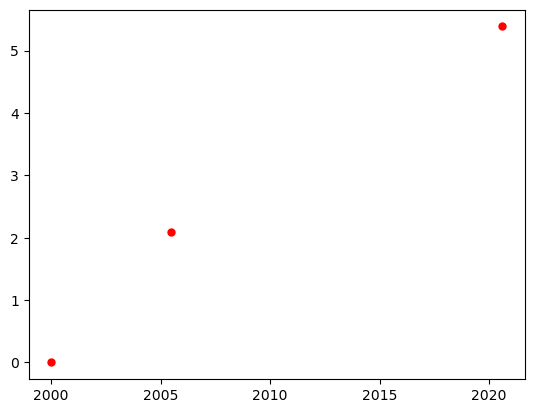

In [49]:
time = [2000, 2005.46, vars_atl06['time_dyr'][0]]
ele_dif_timeseries = [0, 2.1, dif_ele_gla_cor]
plt.plot(time, ele_dif_timeseries, '.r', markersize=10)


In [51]:
### 观测值标准差估算
sigma = np.std(dif_ele_stable)
print(sigma)


20.908055178102924


### 不同高程区间冰川消融速率分析

In [ ]:
ele_bin_1 = [4000, 4500]
ele_bin_2 = [5000, 5500]
### 需要两个数据：冰川高程值（对不同区间观测数据进行分类）和冰川高程变化值
ele_gla_isat2 = vars_atl06['elev'][ids_gla_thre]    ## 冰川高程提取
ids_ele_bin_1 = np.where((ele_gla_isat2>ele_bin_1[0]) 
                         & (ele_gla_isat2<ele_bin_1[1]))  ## 高程区间1对应的冰川观测点索引 
ids_ele_bin_2 = np.where((ele_gla_isat2>ele_bin_2[0]) 
                         & (ele_gla_isat2<ele_bin_2[1]))  ## 高程区间2对应的冰川观测点索引

### elevation bin 1
dif_ele_gla_bin1 = dif_ele_gla[ids_ele_bin_1]
mean_dif_ele_bin1 = dif_ele_gla_bin1.mean()-dif_ele_stable.mean()  ## 冰川高程改正
print('4000-4500:',mean_dif_ele_bin1)

### elevation bin 2
dif_ele_gla_bin2 = dif_ele_gla[ids_ele_bin_2]
mean_dif_ele_bin2 = dif_ele_gla_bin2.mean()-dif_ele_stable.mean()   ## 冰川高程改正
print('5000-5500:',mean_dif_ele_bin2)



4000-4500: 1.7758088456308077
5000-5500: 10.138548252410468
